In [1]:
query = 'RAG'

In [2]:
import os, sys, nltk
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from Preprocess import load_df, load_pickle, load_pickle_files,prep_query
from Searching_Method.Neural_Reranking import retrieve_and_rerank
from Searching_Method.BM25andDenseEmbeddings import load_split_embeddings, combined_ranking
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import matplotlib.pyplot as plt
from rank_bm25 import BM25Okapi
from IPython.display import display, HTML

# preprocess
if os.path.exists('./bm25-vector-search/data/'):
    path = './bm25-vector-search/data/'
elif os.path.exists('./data/'):
    path = './data/'
else:
    print('Error: Could not find data directory')
    print('Please run from either root or bm25-vector-search directory')
    exit(1)

print('Loading DataFrame...')
df = load_df(path + 'arxiv_csAI_subset.json.gz')

print('Loading Pickle Files...')
titles_file = path + 'titles_inverted_indices.pkl.gz'
abstracts_file = path + 'abstracts_inverted_indices.pkl.gz'
title_term_table = load_pickle(titles_file)
abstract_term_table = load_pickle(abstracts_file)

titles_file = path + 'titles_lengths.pkl.gz'
abstracts_file = path + 'abstracts_lengths.pkl.gz'
title_lengths = load_pickle(titles_file)
abstract_lengths = load_pickle(abstracts_file)

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer('english')
# BM25 Configuration Variables
N = len(title_lengths)
avg_doc_len_title = sum(title_lengths.values()) / N
avg_doc_len_abs = sum(abstract_lengths.values()) / N
# Load the split embedding files
document_embeddings = load_split_embeddings(path)
model = SentenceTransformer('all-MiniLM-L6-v2')
query = prep_query(query, stop_words, stemmer)

C:\Users\b0750\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading DataFrame...
Loading Pickle Files...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\b0750\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Level2_Hybrid

In [3]:
titles = list(df['title'].str.lower().str.replace('-', ' ', regex=False).str.replace(r'\s+', ' ', regex=True).str.strip().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\n', '', regex=True).str.replace(r'  ', ' ', regex=True))
abstracts = list(df['abstract'].str.lower().str.replace('-', ' ', regex=False).str.replace(r'\s+', ' ', regex=True).str.strip().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\n', '', regex=True).str.replace(r'  ', ' ', regex=True))
tokenize_titles = [t.split(' ') for t in titles]
tokenize_abstracts = [a.split(' ') for a in abstracts]
titles_bm25 = BM25Okapi(tokenize_titles)
abstracts_bm25 = BM25Okapi(tokenize_abstracts)

In [5]:
google_scholar = [
    'Rag and rau',
    'Raft: Adapting language',
    'Learning to adapt retrieval-augmented',
    'C-rag: Certified generation'
    ]

idxs = []
for t in google_scholar:
  res = df[df['title'].str.contains(t, case=False)]
  if res.size > 0:
    idxs.append(int(res.index[0]))
word = 'neural'
word_count = []
counts_dict = {}
for i, abstract in enumerate(abstracts):
  count = abstract.count(word)
  if count not in counts_dict:
    counts_dict[count] = 0
  if counts_dict[count] < 5:
    word_count.append((i, count))
    counts_dict[count] += 1

word_count = sorted(word_count, key=lambda a: a[1])
word_count = word_count[4:]
all_scores = bm25_search("rag models", top_k='all')
google_scores = [(i, s[0], s[1]) for i, s in enumerate(all_scores) if s[1] in idxs]


In [6]:
papers_to_score = [w[0] for w in word_count]
abstracts_to_score = [tokenize_abstracts[i] for i in papers_to_score]

scores = abstracts_bm25.get_scores([word])

bm25_scores = [scores[i] for i in papers_to_score]

lengths = [len(a) for a in abstracts_to_score]
bm25_counts = [w[1] for w in word_count]

abstracts_texts = [" ".join(a) for a in tokenize_abstracts]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(abstracts_texts)

word_idx = vectorizer.vocabulary_.get(word)


tfidf_scores_all = X[:, word_idx].toarray().flatten()

tfidf_scores = [tfidf_scores_all[i] for i in papers_to_score]

tfidf_counts = [w[1] for w in word_count]
bm25_norm = (bm25_scores - np.min(bm25_scores)) / (np.max(bm25_scores) - np.min(bm25_scores))
tfidf_norm = (tfidf_scores - np.min(tfidf_scores)) / (np.max(tfidf_scores) - np.min(tfidf_scores))

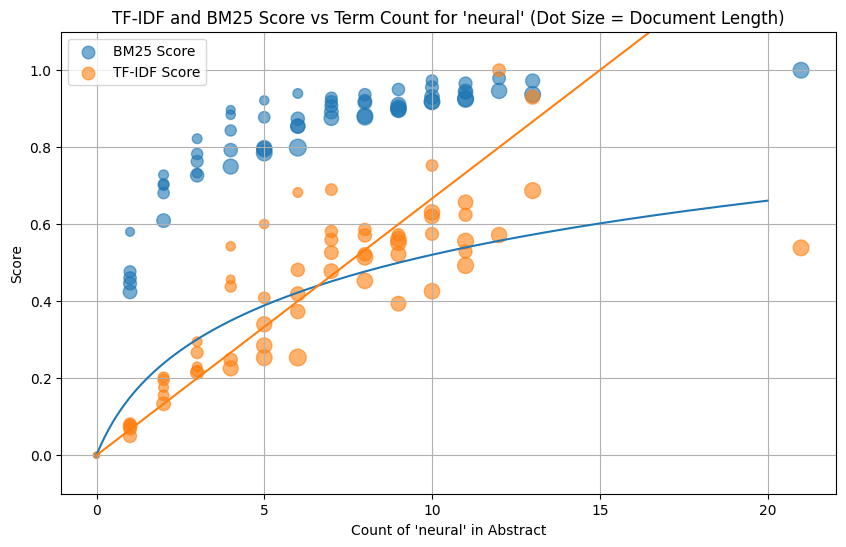

In [7]:
plt.figure(figsize=(10, 6))

sizes = [l / 2 for l in lengths]

# Compare BM25 and Log Curve
plt.scatter(bm25_counts, bm25_norm, s=sizes, alpha=0.6, label="BM25 Score")
x = np.linspace(0, 20, 500)
y1 = np.log10(x + 1) / 2
plt.plot(x, y1)

y2 = x/15
plt.plot(x, y2)
plt.scatter(tfidf_counts, tfidf_norm, s=sizes, alpha=0.6, label="TF-IDF Score")

plt.xlabel(f"Count of '{word}' in Abstract")
plt.ylabel("Score")
plt.title(f"TF-IDF and BM25 Score vs Term Count for '{word}' (Dot Size = Document Length)")
plt.grid(True)
plt.legend()
plt.ylim(-0.1, 1.1)

plt.show()

### The plot shows that TF-IDF increases almost linearly with term frequency, while BM25 saturates and avoids over-rewarding repetition. This indicates that frequency alone does not imply relevance, and BM25 offers a more balanced and context-aware signal—making it better suited for RAG retrieval.

In [8]:
query_embedding = model.encode([query])
similarities = cosine_similarity(query_embedding, document_embeddings)[0]
worst_indices = np.argsort(similarities)[:3]
best_indices = np.argsort(similarities)[::-1][:3]
embeddings = np.concatenate([query_embedding, document_embeddings[best_indices], document_embeddings[worst_indices]], axis=0)

In [9]:
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=5, max_iter=300)
reduced_tsne = tsne.fit_transform(embeddings)

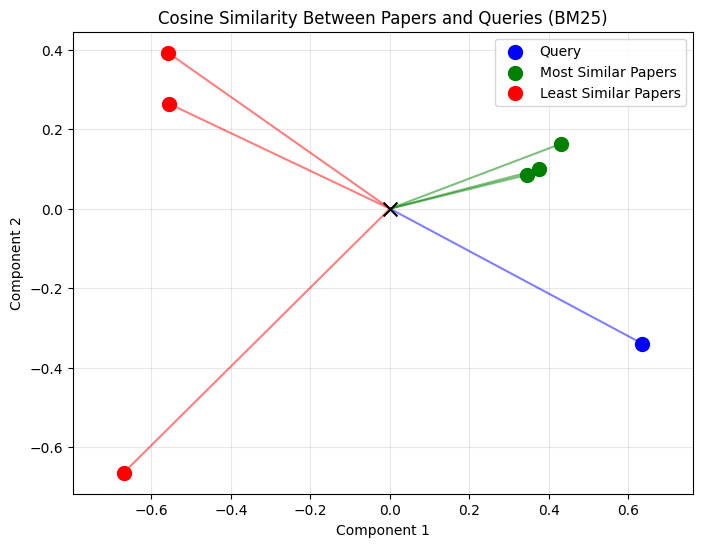

In [10]:
plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red']
labels = ['Query', 'Most Similar Papers', 'Least Similar Papers']
groups = [slice(0, 1), slice(1, 4), slice(4, None)]

for color, label, group in zip(colors, labels, groups):
  points = reduced_pca[group]

  for point in points:
    plt.plot([0, point[0]], [0, point[1]],
              color=color, alpha=0.5, linewidth=1.5)

  plt.scatter(points[:, 0], points[:, 1],
              color=color, label=label, s=100, zorder=5)

plt.scatter(0, 0, color='black', s=100, marker='x', zorder=10)

plt.title('Cosine Similarity Between Papers and Queries (BM25)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

### Relevant papers cluster near the query, while irrelevant ones diverge sharply—showing BM25 clearly distinguishes meaningful matches.

## Level 3_Reranking

In [11]:
 #  Neural Reranking with Cross-Encoders
 print("Using Corss Encode to reranking top 100 files")
 candidates = combined_ranking(query, 100, title_term_table, abstract_term_table, title_lengths, abstract_lengths, avg_doc_len_title, avg_doc_len_abs, N, model, document_embeddings)

 candidates_with_text = []
 # put in the text to rerank 
 for doc_id, score in candidates:
     abstract = df.iloc[doc_id].get("abstract", "")
     title    = df.iloc[doc_id].get("title", "")
     text     = title + " " + abstract            
     candidates_with_text.append((doc_id, text))

 reranked = retrieve_and_rerank(
     query,
     candidates_with_text,
     tokenizer_model = "bert-base-uncased",
     cross_encoder_model = "bert-base-uncased"
 )

Using Corss Encode to reranking top 100 files


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
# write the results from level2 and level 3 into dataframe
original_ranks = {doc_id: rank for rank, (doc_id, _) in enumerate(candidates, start=1)}

rows = []
for rank_after, (score_after, doc_id, text) in enumerate(reranked, start=1):
    row = df.iloc[doc_id]
    rows.append({
        "doc_id": doc_id,
        "score_after": score_after,
        "rank_after": rank_after,
        "rank_before": original_ranks.get(doc_id, None),
        "title": row.get("title", ""),
        "update_date": row.get("update_date", None),
        "arxiv_id": row.get("id", None),
    })

results_df = pd.DataFrame(rows)

if results_df["update_date"].dtype == "object":
    results_df["update_date"] = pd.to_datetime(results_df["update_date"], errors="coerce")

results_df.head()


,doc_id,score_after,rank_after,rank_before,title,update_date,arxiv_id
0,96449,0.235488,1,23,Rag and Roll: An End-to-End Evaluation of Indi...,2024-08-13,2408.05025
1,141797,0.234260,2,72,RAG Security and Privacy: Formalizing the Thre...,2025-09-25,2509.20324
2,92845,0.141611,3,45,Pistis-RAG: Enhancing Retrieval-Augmented Gene...,2024-11-04,2407.00072
3,96435,0.123716,4,40,ConfusedPilot: Confused Deputy Risks in RAG-ba...,2024-10-24,2408.04870
4,119988,0.121617,5,89,Contradiction Detection in RAG Systems: Evalua...,2025-04-02,2504.00180


### The cross-encoder reranker noticeably reshapes the ranking results by promoting papers that were originally much lower in the candidate list but more semantically relevant to the query. This shows that neural reranking provides finer-grained relevance judgment than BM25 and dense embeddings alone.

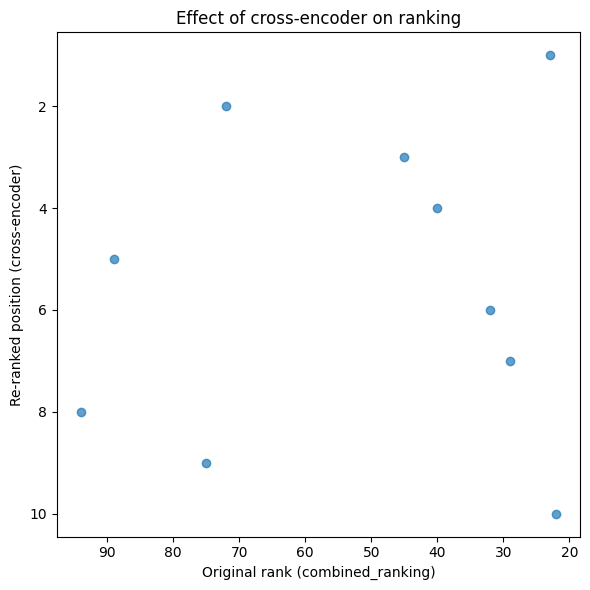

In [13]:
# ranking vs reranked

valid_df = results_df.dropna(subset=["rank_before"])

plt.figure(figsize=(6, 6))
plt.scatter(valid_df["rank_before"], valid_df["rank_after"], alpha=0.7)
plt.xlabel("Original rank (combined_ranking)")
plt.ylabel("Re-ranked position (cross-encoder)")
plt.title("Effect of cross-encoder on ranking")


plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


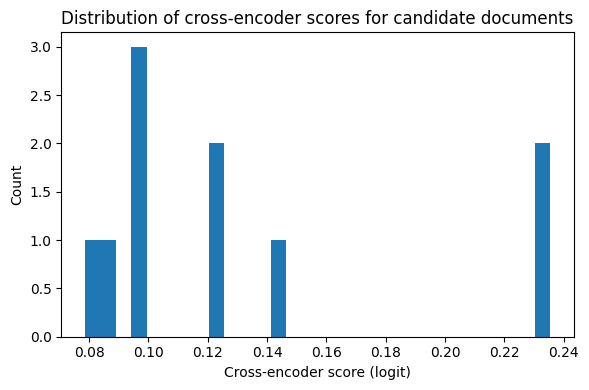

In [14]:
plt.figure(figsize=(6, 4))
plt.hist(results_df["score_after"], bins=30)
plt.xlabel("Cross-encoder score (logit)")
plt.ylabel("Count")
plt.title("Distribution of cross-encoder scores for candidate documents")
plt.tight_layout()
plt.show()
